In [1]:
# 1. Imports
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import cv2


In [4]:
import os
import pandas as pd

# Load CSV files
train_df = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')
test_df = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv')

# Confirm image folders
train_img_dir = "/kaggle/input/soil-classification/soil_classification-2025/train"
test_img_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"

# Add full file paths using 'image_id' instead of 'filename'
train_df['filepath'] = train_df['image_id'].apply(lambda x: os.path.join(train_img_dir, x))
test_df['filepath'] = test_df['image_id'].apply(lambda x: os.path.join(test_img_dir, x))



In [5]:
# 3. Dataset Class with Augmentations
class SoilDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if 'label_id' in self.df.columns:
            label = row['label_id']
            return image, label
        else:
            return image


In [6]:
# 4. Transformations
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(image_size, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [10]:
from sklearn.preprocessing import LabelEncoder

# OPTIONAL: Rename columns if not already done
train_df.rename(columns={'image_id': 'filename', 'soil_type': 'label'}, inplace=True)

# Encode soil labels to integers
label_encoder = LabelEncoder()
train_df['label_id'] = label_encoder.fit_transform(train_df['label'])  # Adds 'label_id' column


In [11]:
# 5. Stratified Split + Weighted Sampling
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['label_id'], random_state=42)

# Class weights
class_counts = train_data['label_id'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_data['label_id'].values]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = SoilDataset(train_data, transform=train_transform)
val_dataset = SoilDataset(val_data, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [14]:
# 6. Model Setup

import torch
import torch.nn as nn
from torchvision import models

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Get number of soil classes from LabelEncoder
num_classes = len(label_encoder.classes_)

# Load ResNet18 with pretrained weights (new API)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace the final classification layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
model = model.to(device)

# Print model summary
print(model)


Using device: cpu
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [15]:
# 7. Training Loop Setup

import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np

# Define loss function with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_data['label_id']),
                                     y=train_data['label_id'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Custom training loop
def train_model(model, criterion, optimizer, epochs=15):
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        true_labels = []
        pred_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

        # Calculate F1 for each class
        f1_scores = f1_score(true_labels, pred_labels, average=None)
        min_f1 = f1_scores.min()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Min F1: {min_f1:.4f}")

        # Save best model
        if min_f1 > best_f1:
            best_f1 = min_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model saved with new best Min F1:", best_f1)

# Now run training
train_model(model, criterion, optimizer, epochs=15)


Epoch 1/15 - Loss: 12.2804 - Min F1: 0.7963
✅ Model saved with new best Min F1: 0.7962529274004684
Epoch 2/15 - Loss: 4.8638 - Min F1: 0.9091
✅ Model saved with new best Min F1: 0.9090909090909091
Epoch 3/15 - Loss: 2.8355 - Min F1: 0.9543
✅ Model saved with new best Min F1: 0.9542743538767395
Epoch 4/15 - Loss: 2.4869 - Min F1: 0.9461
Epoch 5/15 - Loss: 1.8860 - Min F1: 0.9493
Epoch 6/15 - Loss: 1.2703 - Min F1: 0.9645
✅ Model saved with new best Min F1: 0.964509394572025
Epoch 7/15 - Loss: 1.2552 - Min F1: 0.9632
Epoch 8/15 - Loss: 2.4603 - Min F1: 0.9602
Epoch 9/15 - Loss: 1.2001 - Min F1: 0.9679
✅ Model saved with new best Min F1: 0.9678714859437751
Epoch 10/15 - Loss: 0.6637 - Min F1: 0.9828
✅ Model saved with new best Min F1: 0.9827586206896551
Epoch 11/15 - Loss: 0.6017 - Min F1: 0.9881
✅ Model saved with new best Min F1: 0.9881422924901185
Epoch 12/15 - Loss: 1.3802 - Min F1: 0.9587
Epoch 13/15 - Loss: 2.0086 - Min F1: 0.9794
Epoch 14/15 - Loss: 1.9862 - Min F1: 0.9569
Epoch 15


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.96      0.98       106
   Black Soil       0.96      1.00      0.98        46
    Clay soil       0.95      1.00      0.98        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.98       245
    macro avg       0.98      0.99      0.98       245
 weighted avg       0.98      0.98      0.98       245



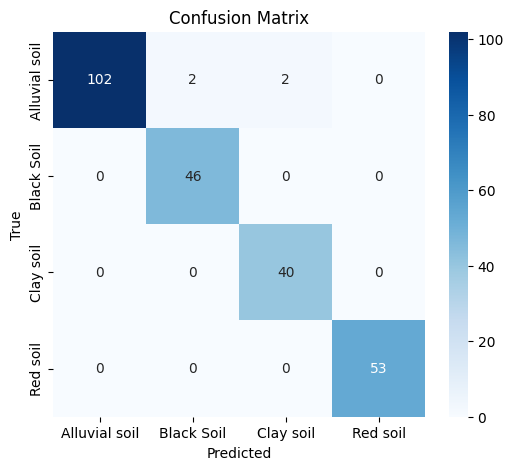

In [17]:
# 8. Confusion Matrix and F1 Score on Validation Set

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Put model in evaluation mode and load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# F1 score report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# 9. Test Prediction and Submission

# Map label indices back to class names
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}

# Put model in evaluation mode
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Prepare test loader (if not already done)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Make predictions
all_preds = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

# Add predictions to test_df
test_df['label_id'] = all_preds
test_df['label'] = test_df['label_id'].map(id2label)

# If filenames are in 'image_id', rename for submission
submission = test_df.rename(columns={"image_id": "filename"})[['filename', 'label']]
submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' created!")
submission.head()


✅ Submission file 'submission.csv' created!


,filename,label
0,img_cdf80d6f.jpeg,Alluvial soil
1,img_c0142a80.jpg,Alluvial soil
2,img_91168fb0.jpg,Alluvial soil
3,img_9822190f.jpg,Alluvial soil
4,img_e5fc436c.jpeg,Alluvial soil
